In [1]:
N_CLONES = 2000
DB_PATH = f"../data/synthetic/raw/cld_{N_CLONES}clones.db"

# Notebook 04 — Multi-objective Early Clone Selection Simulation (Commercial-style)

## Goal
Simulate early clone selection as a **commercial** decision problem:
- High productivity (late-stage titer)
- High stability (low drop)
- Good quality (low aggregation proxy)

We compare selection strategies under two retention policies:
- retain 20% (conservative)
- retain 10% (aggressive)

Selection strategies:
1) Baseline: early titer ranking
2) Baseline: random selection
3) ML: predicted stability-drop ranking
4) ML: **multi-objective score** (stability + productivity + quality)

## Why multi-objective?
In real CLD/bioprocess development, we do not optimize a single metric.
We need stable, productive, and high-quality clones — especially for late passage / perfusion readiness.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
FEATURE_PATH = "../data/synthetic/processed/cld_features_with_label.csv"
dataset = pd.read_csv(FEATURE_PATH)

DB_PATH = "../data/synthetic/raw/cld.db"
conn = sqlite3.connect(DB_PATH)

dataset.head()

,clone_id,titer_mean,titer_std,titer_min,titer_max,vcd_mean,vcd_std,vcd_min,vcd_max,viability_mean,...,viability_max,aggregation_mean,aggregation_std,aggregation_min,aggregation_max,titer_slope,vcd_slope,viability_slope,aggregation_slope,productivity_drop_pct
0,CLONE_0001,2.538067,0.293036,2.223711,2.964514,1.107619e+07,9.052556e+05,9.779103e+06,1.232258e+07,94.851455,...,97.386709,8.356812,0.403848,7.723455,8.894030,-0.103703,102268.665747,0.169734,-0.019225,0.387063
1,CLONE_0002,0.814721,0.213007,0.537981,1.132518,1.441091e+07,1.047019e+06,1.346070e+07,1.605341e+07,97.551824,...,99.573812,7.337188,0.449925,6.798531,8.011004,-0.005035,279733.381794,0.198861,-0.023819,0.135156
2,CLONE_0003,3.912552,0.208697,3.621956,4.261524,8.684126e+06,5.834120e+05,7.780120e+06,9.384241e+06,94.390688,...,98.774683,2.235352,0.326064,1.745532,2.861836,-0.058117,51853.805966,0.505344,0.038583,0.335258
3,CLONE_0004,0.488369,0.160312,0.212916,0.747609,1.511725e+07,7.817665e+05,1.405453e+07,1.606425e+07,96.380534,...,98.968096,3.860240,0.305128,3.357574,4.286918,-0.026671,278866.456374,0.504642,0.051834,0.590633
4,CLONE_0005,2.238289,0.160672,2.033612,2.459557,1.117195e+07,1.167196e+06,8.874346e+06,1.239030e+07,95.085238,...,96.870619,3.231717,0.405157,2.620058,4.001488,-0.034059,391064.583721,0.233446,-0.129212,0.291757


## Train a regressor for predicted stability drop

We train a model to predict stability drop using early features.
We will use predicted drop as one input into the multi-objective score.

Note: even if regression is not perfect, it can still provide a useful ranking signal.

In [4]:
# y: clamp negative to 0 ("no drop")
y = dataset["productivity_drop_pct"].copy().clip(lower=0.0, upper=1.0)

# X: features only
X = dataset.drop(columns=["clone_id", "productivity_drop_pct"]).copy()
X = X.fillna(X.median(numeric_only=True))

clone_ids = dataset["clone_id"].copy()

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, clone_ids, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    min_samples_leaf=5,
    max_features="sqrt"
)
rf.fit(X_train, y_train)

pred_test = rf.predict(X_test)
print("RF MAE:", mean_absolute_error(y_test, pred_test))
print("RF R2 :", r2_score(y_test, pred_test))

RF MAE: 0.08359412202009618
RF R2 : 0.029879706732028777


## Build decision table for held-out clones (test set)

We simulate selection only on clones not used for training.
This avoids trivial leakage and better mimics real deployment.

In [5]:
test_table = pd.DataFrame({
    "clone_id": id_test.values,
    "true_drop": y_test.values,
    "pred_drop": pred_test,
})

# Add key early features used in commercial decisions
# (these are early-window features from Notebook 02)
test_table["titer_mean"] = X_test["titer_mean"].values
test_table["aggregation_mean"] = X_test["aggregation_mean"].values

test_table.head()

,clone_id,true_drop,pred_drop,titer_mean,aggregation_mean
0,CLONE_0362,0.381576,0.260317,0.721936,9.437194
1,CLONE_0074,0.240289,0.267880,0.747163,2.173795
2,CLONE_0375,0.210410,0.239075,4.346136,7.514381
3,CLONE_0156,0.223388,0.291669,2.181751,2.861650
4,CLONE_0105,0.414974,0.260359,1.050794,4.595682


## Compute late-stage outcomes from the raw DB

We compute late-stage metrics (passage 26–30):
- late_mean_titer (productivity at late stage)
- late_mean_aggregation (quality proxy at late stage)

These are used to evaluate whether selection policies improve real outcomes.

In [6]:
def fetch_late_means(conn, clone_list, late_start=26, late_end=30):
    if len(clone_list) == 0:
        return pd.DataFrame(columns=["clone_id", "late_mean_titer", "late_mean_aggregation"])

    placeholders = ",".join(["?"] * len(clone_list))

    query = f"""
    SELECT p.clone_id,
           AVG(CASE WHEN ar.assay_type='titer' THEN ar.value END) AS late_mean_titer,
           AVG(CASE WHEN ar.assay_type='aggregation' THEN ar.value END) AS late_mean_aggregation
    FROM assay_result ar
    JOIN passage p ON p.passage_id = ar.passage_id
    WHERE p.passage_number BETWEEN ? AND ?
      AND p.clone_id IN ({placeholders})
    GROUP BY p.clone_id
    """
    params = [late_start, late_end] + list(clone_list)
    return pd.read_sql_query(query, conn, params=params)

late_metrics_test = fetch_late_means(conn, test_table["clone_id"].tolist(), 26, 30)
late_metrics_test.head()

,clone_id,late_mean_titer,late_mean_aggregation
0,CLONE_0001,1.555675,8.137307
1,CLONE_0003,2.600837,2.209127
2,CLONE_0010,0.845235,1.484692
3,CLONE_0012,1.098513,5.089938
4,CLONE_0016,3.331767,5.319159


## Merge late outcomes into decision table

Now each held-out clone has:
- early features (titer_mean, aggregation_mean)
- predicted stability drop (pred_drop)
- true stability drop (true_drop)
- late outcomes (late_mean_titer, late_mean_aggregation)

In [7]:
test_table = test_table.merge(late_metrics_test, on="clone_id", how="left")
test_table.head()

,clone_id,true_drop,pred_drop,titer_mean,aggregation_mean,late_mean_titer,late_mean_aggregation
0,CLONE_0362,0.381576,0.260317,0.721936,9.437194,0.446462,9.422737
1,CLONE_0074,0.240289,0.267880,0.747163,2.173795,0.567628,2.278765
2,CLONE_0375,0.210410,0.239075,4.346136,7.514381,3.431665,7.793618
3,CLONE_0156,0.223388,0.291669,2.181751,2.861650,1.694375,3.306579
4,CLONE_0105,0.414974,0.260359,1.050794,4.595682,0.614742,4.700792


## Define selection policies and multi-objective score

We define a multi-objective score that rewards:
- higher early titer_mean (proxy for productivity)
- lower predicted drop (stability)
- lower early aggregation_mean (quality)

Because these metrics have different units, we normalize them using z-scores
computed on the held-out test set.

Score definition (example):
score =  w_titer * z(titer_mean)
       - w_drop  * z(pred_drop)
       - w_agg   * z(aggregation_mean)

Weights can be tuned based on product/process priorities.

In [8]:
def zscore(s):
    s = s.astype(float)
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

# z-score normalize within the held-out decision universe (test_table)
test_table["z_titer_mean"] = zscore(test_table["titer_mean"])
test_table["z_pred_drop"]  = zscore(test_table["pred_drop"])
test_table["z_agg_mean"]   = zscore(test_table["aggregation_mean"])

# Weights (tune these later)
W_TITER = 1.0
W_DROP  = 1.0
W_AGG   = 0.5   # quality weight (can be higher for rare-disease mode)

test_table["score_multi"] = (
    W_TITER * test_table["z_titer_mean"]
    - W_DROP  * test_table["z_pred_drop"]
    - W_AGG   * test_table["z_agg_mean"]
)

def retain_top_fraction(df, score_col, fraction, higher_is_better=True, seed=42):
    n = int(np.ceil(len(df) * fraction))
    n = max(1, n)

    if score_col == "random":
        rng = np.random.default_rng(seed)
        return df.iloc[rng.choice(len(df), size=n, replace=False)].copy()

    ascending = not higher_is_better
    return df.sort_values(score_col, ascending=ascending).head(n).copy()

fractions = [0.20, 0.10]

## Evaluate selection outcomes

For each method and retention policy, we report:
- mean_true_drop (lower = better stability)
- stable_rate (true_drop <= 0.15)
- mean_late_titer (higher = better productivity)
- mean_late_aggregation (lower = better quality)

In [9]:
def summarize_selection(df_sel, stable_cutoff=0.15):
    return {
        "n_selected": len(df_sel),
        "mean_true_drop": df_sel["true_drop"].mean(),
        "stable_rate(true_drop<=0.15)": (df_sel["true_drop"] <= stable_cutoff).mean(),
        "mean_late_titer": df_sel["late_mean_titer"].mean(),
        "mean_late_aggregation": df_sel["late_mean_aggregation"].mean(),
    }

rows = []

for frac in fractions:
    # Baseline A: early titer ranking
    sel_titer = retain_top_fraction(test_table, "titer_mean", frac, higher_is_better=True)
    rows.append({"method": "baseline_titer", "retain_frac": frac, **summarize_selection(sel_titer)})

    # Baseline B: random
    sel_rand = retain_top_fraction(test_table, "random", frac, higher_is_better=True)
    rows.append({"method": "baseline_random", "retain_frac": frac, **summarize_selection(sel_rand)})

    # ML-guided (stability only): predicted drop
    sel_drop = retain_top_fraction(test_table, "pred_drop", frac, higher_is_better=False)
    rows.append({"method": "ml_pred_drop", "retain_frac": frac, **summarize_selection(sel_drop)})

    # ML-guided (commercial multi-objective): score_multi
    sel_multi = retain_top_fraction(test_table, "score_multi", frac, higher_is_better=True)
    rows.append({"method": "ml_multi_score", "retain_frac": frac, **summarize_selection(sel_multi)})

results_df = pd.DataFrame(rows)
results_df

,method,retain_frac,n_selected,mean_true_drop,stable_rate(true_drop<=0.15),mean_late_titer,mean_late_aggregation
0,baseline_titer,0.2,20,0.277346,0.00,2.831909,5.122312
1,baseline_random,0.2,20,0.251889,0.10,1.030118,5.304055
2,ml_pred_drop,0.2,20,0.228704,0.25,1.779079,5.332218
3,ml_multi_score,0.2,20,0.260547,0.10,2.811442,5.193087
4,baseline_titer,0.1,10,0.278338,0.00,3.532133,5.291544
5,baseline_random,0.1,10,0.244168,0.10,1.642611,6.442249
6,ml_pred_drop,0.1,10,0.180399,0.40,1.755803,5.147358
7,ml_multi_score,0.1,10,0.262177,0.10,3.076800,5.131812


## Pareto-like visualization (stability vs productivity)

We plot each method in a 2D trade-off space:
- x-axis: mean_late_titer (higher is better)
- y-axis: mean_true_drop (lower is better)

The best methods are generally toward the **top-right?**  
Careful: Here “better” is **right (high titer)** and **down (low drop)**,
so the best region is **bottom-right**.

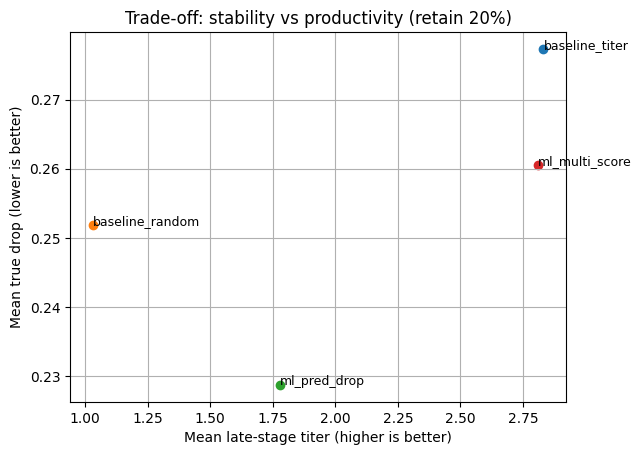

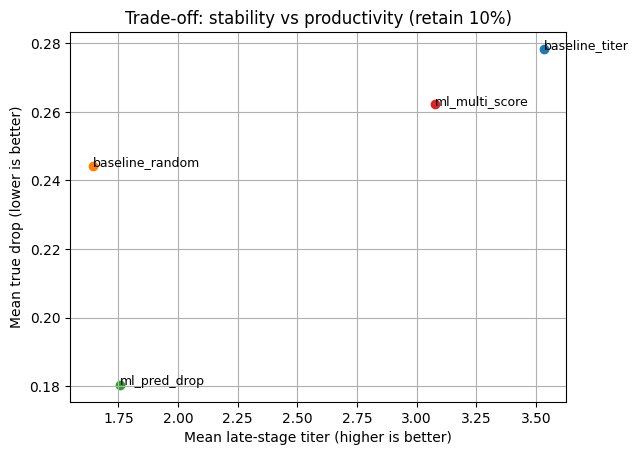

In [10]:
def plot_tradeoff(sub, title):
    plt.figure()
    for _, r in sub.iterrows():
        plt.scatter(r["mean_late_titer"], r["mean_true_drop"])
        plt.text(r["mean_late_titer"], r["mean_true_drop"], r["method"], fontsize=9)

    plt.title(title)
    plt.xlabel("Mean late-stage titer (higher is better)")
    plt.ylabel("Mean true drop (lower is better)")
    plt.grid(True)
    plt.show()

for frac in fractions:
    sub = results_df[results_df["retain_frac"] == frac].copy()
    plot_tradeoff(sub, f"Trade-off: stability vs productivity (retain {int(frac*100)}%)")

## (Optional) Clone-level Pareto view for selected sets

We plot the selected clones in the test set:
- x: late_mean_titer
- y: true_drop

This shows whether a method selects clones closer to the desired region:
high late titer + low drop (bottom-right).

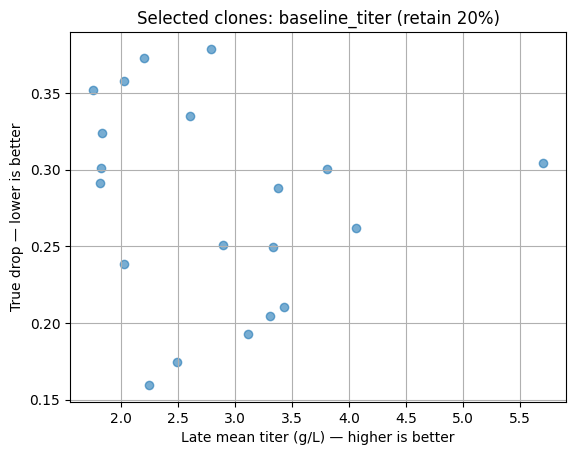

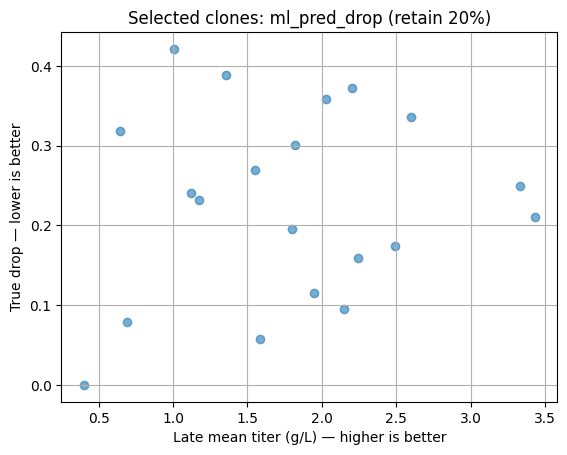

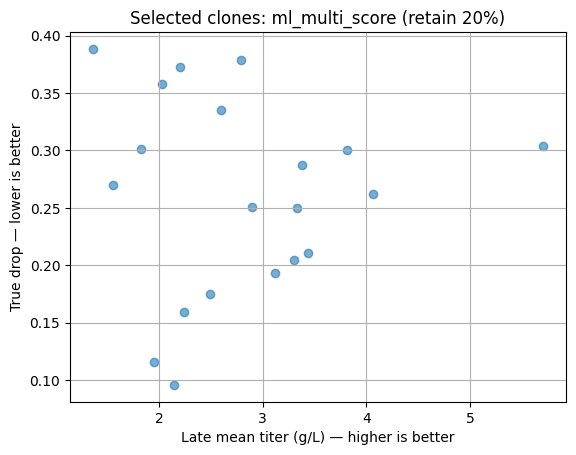

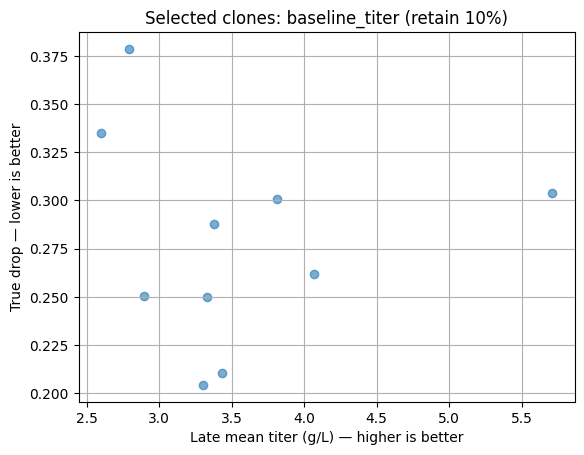

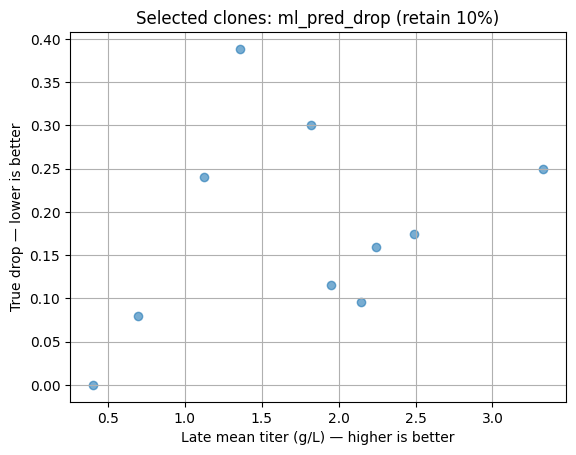

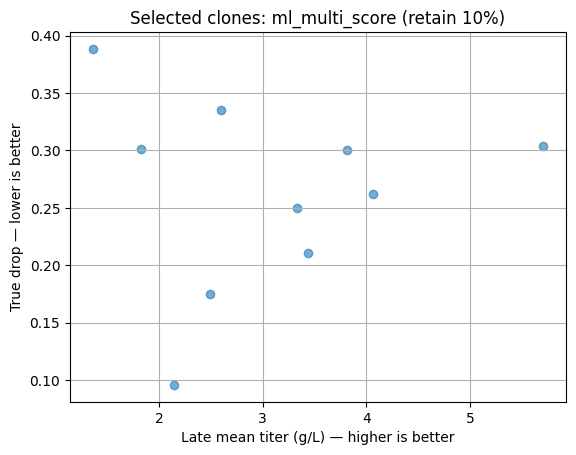

In [11]:
def plot_selected_cloud(sel_df, title):
    plt.figure()
    plt.scatter(sel_df["late_mean_titer"], sel_df["true_drop"], alpha=0.6)
    plt.title(title)
    plt.xlabel("Late mean titer (g/L) — higher is better")
    plt.ylabel("True drop — lower is better")
    plt.grid(True)
    plt.show()

for frac in fractions:
    sel_titer = retain_top_fraction(test_table, "titer_mean", frac, True)
    sel_drop  = retain_top_fraction(test_table, "pred_drop", frac, False)
    sel_multi = retain_top_fraction(test_table, "score_multi", frac, True)

    plot_selected_cloud(sel_titer, f"Selected clones: baseline_titer (retain {int(frac*100)}%)")
    plot_selected_cloud(sel_drop,  f"Selected clones: ml_pred_drop (retain {int(frac*100)}%)")
    plot_selected_cloud(sel_multi, f"Selected clones: ml_multi_score (retain {int(frac*100)}%)")

In [12]:
conn.close()
print("DB connection closed.")

DB connection closed.
